# Challenge 1: Classification
In this challenge, you're given a food classification dataset which has 101 classes. You need to analyze and preprocess the dataset as well as build deep learning models for performing food classification. 

You are also required to write a function to apply an augmentation as explained below: <br>
1) Take 5 random images (numpy format) as an input to the function. <br>
2) Randomly arrange the 5 images in a single image while preserving the aspect ratio of each image. <br>
3) Final image size should be an input parameter to the function. <br>
4) Output format shall be numpy format. 
(Note - If required, you can use this augmentation function while training the models). <br>

<br>
Two models are to be trained for this task, mainly light, and medium model. <br>
Examples: <br>
Light model - mobilenetv2 <br>
Medium model - Resnet50 <br>
<br>

**Main Objective**:
You are supposed to use both TensorFlow and PyTorch for this task. You need to train one model for each framework. 

## Summary 

**Create a table for your train and test accuracy as well as speed for each model (mention the framework used for training)**

## Augmentation function given in the problem statement

# Importing Libraries

In [1]:
import numpy as np
import os
import pandas as pd


import shutil
import matplotlib.pyplot as plt
import configparser
import secrets
import cv2
import random
import sys

from PIL import Image
from PIL import ImageFile        
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential,Model
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image                  
from tqdm import tqdm

from keras.applications.vgg16 import VGG16

from keras import optimizers
from keras.applications.mobilenet import MobileNet

import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [2]:

# def augmentation_function(input_images: List[numpy.ndarray], final_image_size: Tuple) -> numpy.ndarray:
#     """Apply augmentation to a set of 5 images
#     Args:
#         input_images (List[numpy.ndarray]): List of 5 images in numpy format
#         final_image_size (Tuple): A tuple of final image size in the format (width, height, channels)
    
#     Returns:
#         Image (numpy.ndarray): Augmented image
#     """
#     pass

# 1.0 DATA ANALYSIS

## 1.1 Setting up folders 

In [3]:
DATA_AUG = os.path.join(os.getcwd(),"data","prepare_augmented_data")

if not os.path.exists(DATA_AUG):
    os.makedirs(DATA_AUG)
    

In [4]:
VALIDATE_DIR = os.path.join(os.getcwd(),"data","validation")
TRAIN_DIR = os.path.join(os.getcwd(),"data","training")
MODEL_PATH = os.path.join(os.getcwd(),"model","light_model")
PICKLE_DIR = os.path.join(os.getcwd(),"pickle_files")
CSV_DIR = os.path.join(os.getcwd(),"csv_files")

In [5]:
if not os.path.exists(VALIDATE_DIR):
    print("VALIDATION data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

## 1.2 Creating Training and Validation csv 

I create the training and validation csv files having the filepath and corresponding class name for easy locating them and further usage in augmentation

In [6]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(CSV_DIR,filename),index=False)

create_csv(TRAIN_DIR,"train.csv")
create_csv(VALIDATE_DIR,"validate.csv")

data_train = pd.read_csv(os.path.join(os.getcwd(),"csv_files","train.csv"))
data_validate = pd.read_csv(os.path.join(os.getcwd(),"csv_files","validate.csv"))

In [7]:
data_train.head()

Filename  ClassName
0  D:\ML_Projects\Food_Classifier\Code\data\train...  apple_pie
1  D:\ML_Projects\Food_Classifier\Code\data\train...  apple_pie
2  D:\ML_Projects\Food_Classifier\Code\data\train...  apple_pie
3  D:\ML_Projects\Food_Classifier\Code\data\train...  apple_pie
4  D:\ML_Projects\Food_Classifier\Code\data\train...  apple_pie

In [8]:
# food dist is the dataframe containing the food category with number of files corresponding it
food_dist = list()
for idx,num_files in enumerate(data_train['ClassName'].value_counts()):
    food_dist.append({
        "FoodName":data_train['ClassName'].value_counts().index[idx],
        "NumFiles":num_files
    })
food_dist = pd.DataFrame(food_dist)


food_dist.head(10) # shows the classwise distribution of data

FoodName  NumFiles
0    apple_pie      1000
1    miso_soup      1000
2  peking_duck      1000
3  panna_cotta      1000
4     pancakes      1000
5       paella      1000
6     pad_thai      1000
7      oysters      1000
8  onion_rings      1000
9     omelette      1000

In [9]:
data_train.describe()

Filename  ClassName
count                                              101000     101000
unique                                             101000        101
top     D:\ML_Projects\Food_Classifier\Code\data\train...  apple_pie
freq                                                    1       1000

In [10]:
data_train = pd.read_csv(os.path.join(CSV_DIR,"train.csv"))
data_validate = pd.read_csv(os.path.join(CSV_DIR,"validate.csv"))

data_train['Filename'] = data_train['Filename'].apply(lambda x:os.path.join(CSV_DIR,"train",x))
data_validate['Filename'] = data_validate['Filename'].apply(lambda x:os.path.join(CSV_DIR,"test",x))

print("The number of training images is ",data_train.shape[0])
print("The number of testing images is ",data_validate.shape[0])

The number of training images is  101000
The number of testing images is  10100


## 1.3 Visualizing the data samples 

Following code visualized the sample images from apple pie class

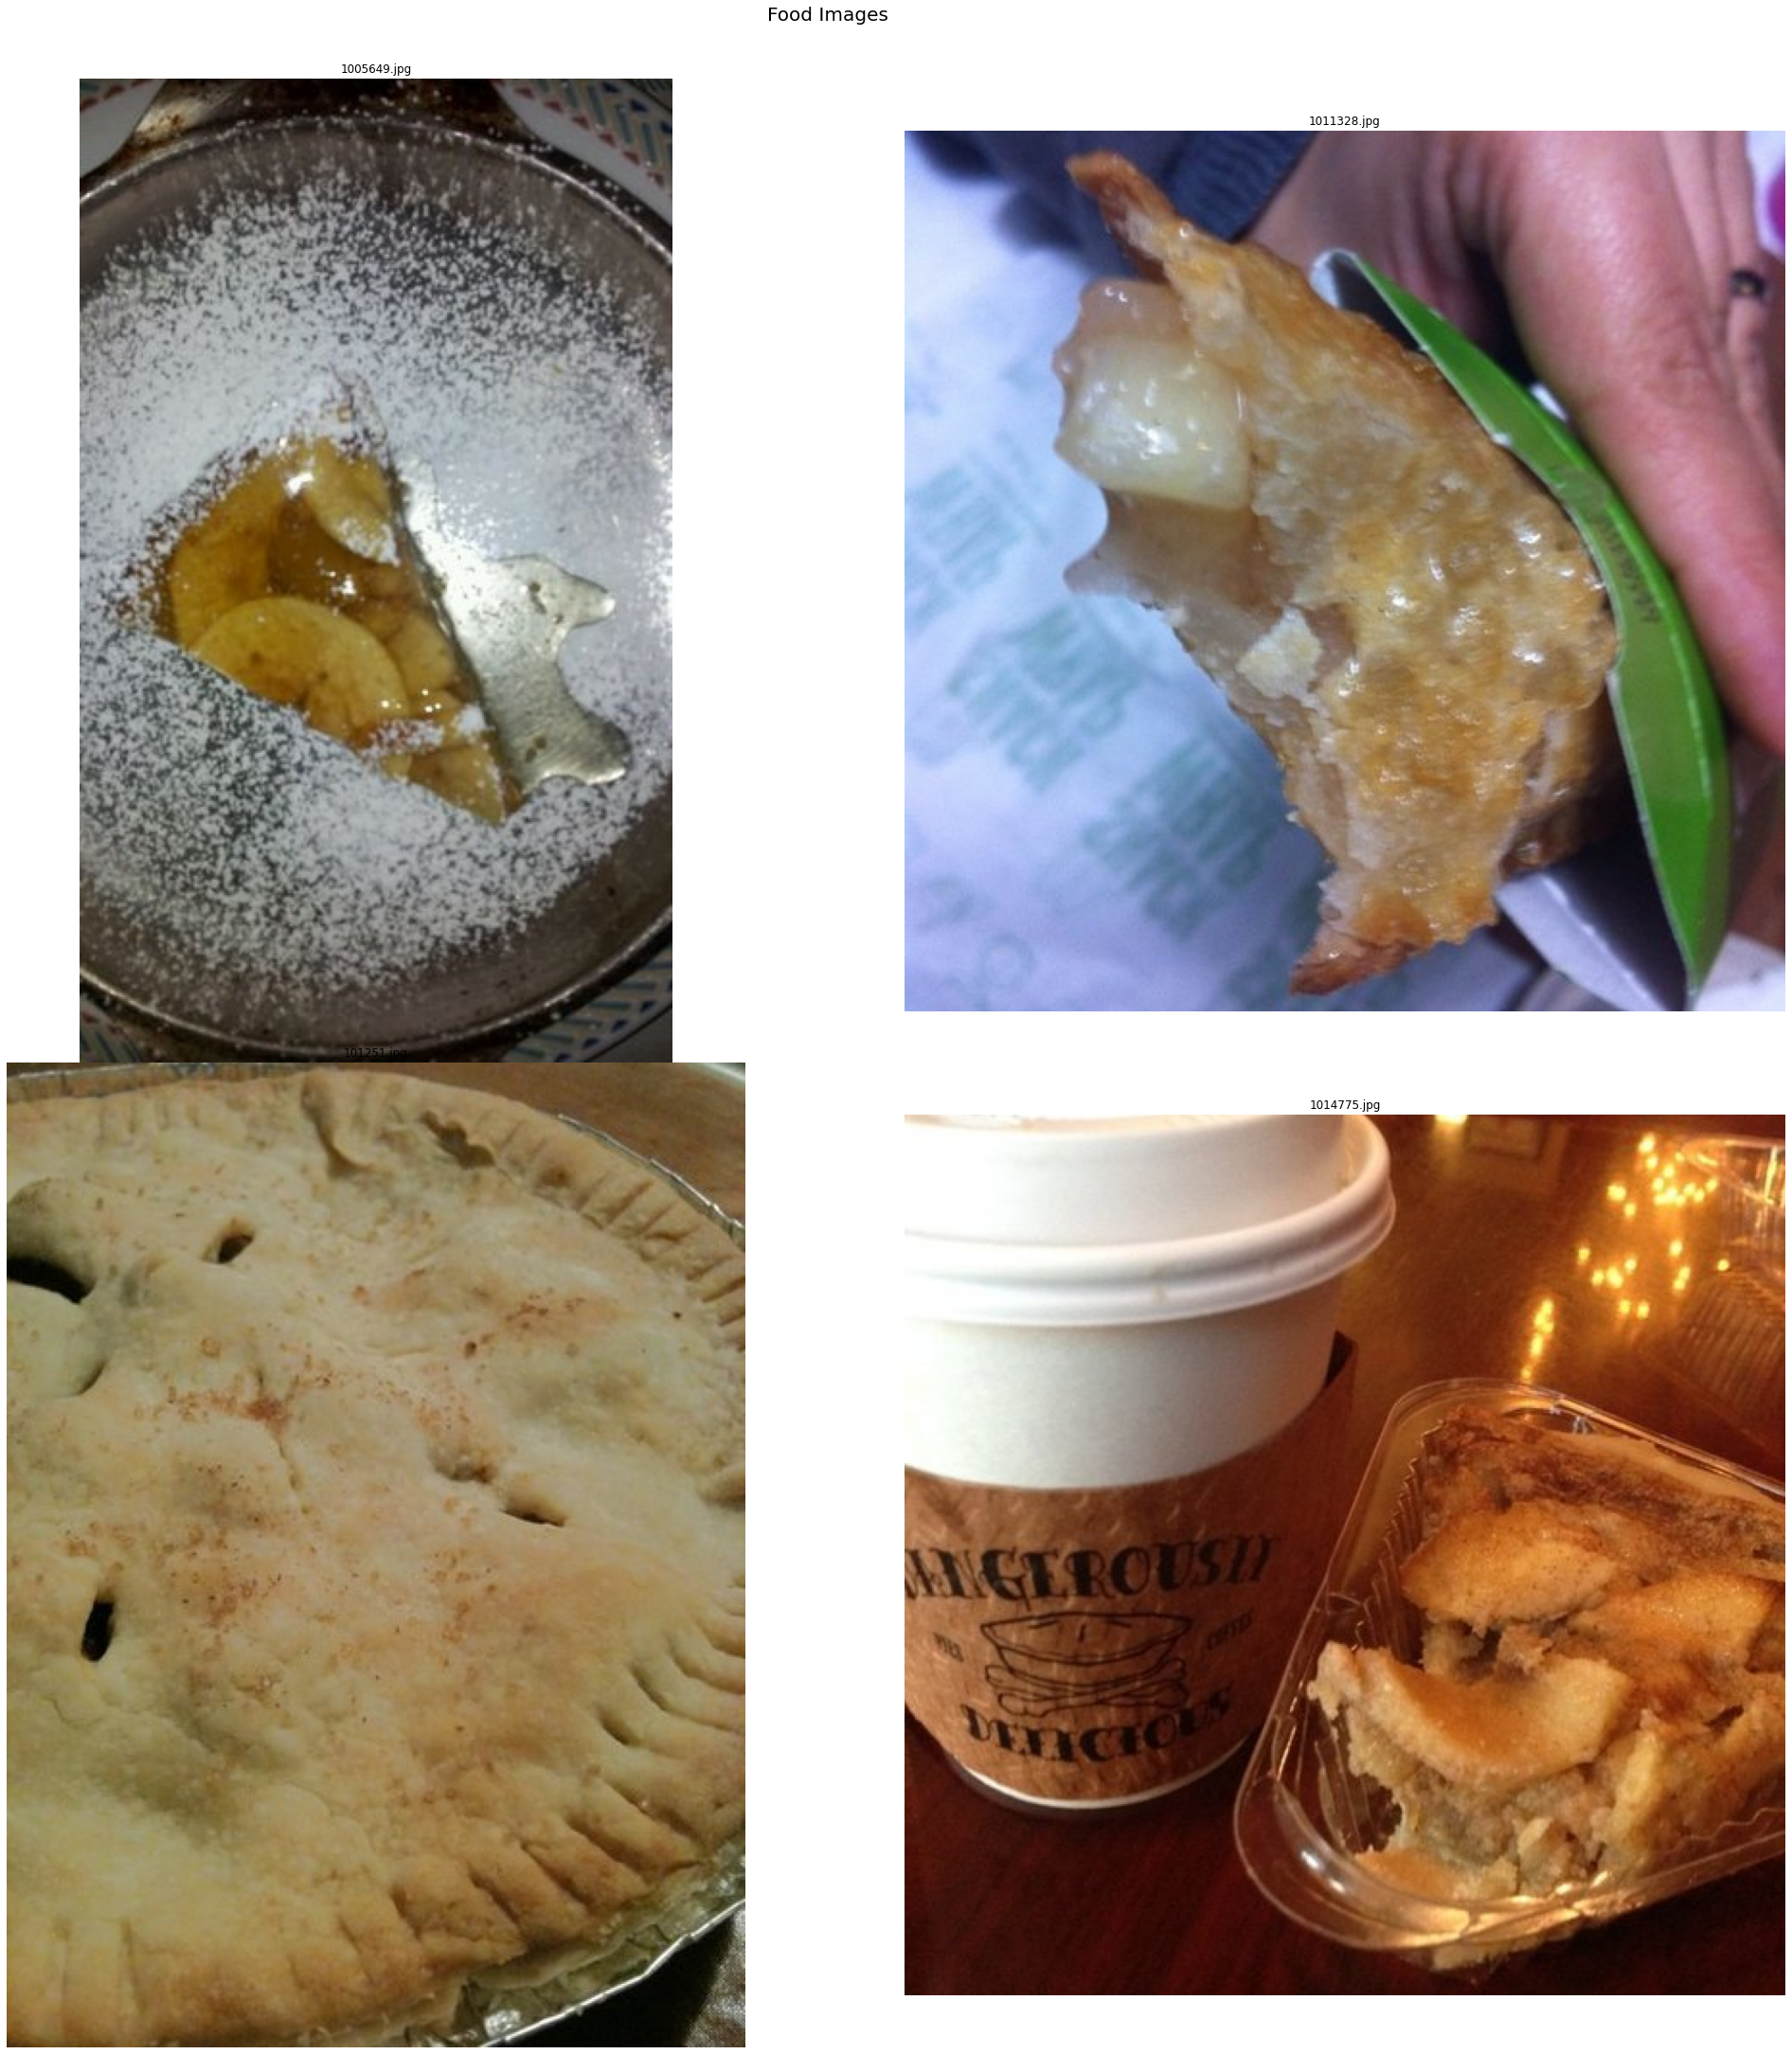

In [11]:
fig = plt.figure(figsize=(35,35))
size1, size2 = 2 ,2
plt.suptitle( 'Food Images ' , fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.95, wspace=0.1, hspace=0)
ind = 1
for i in range(size1):
    for j in range(size2):
        plt.subplot(size1,size2,ind)
        path = data_train.iloc[ind-1,0]
        ind += 1
        image = Image.open(path)#skimage.io.imread(path)
        plt.imshow(image)#.astype(np.uint8))
        plt.title(path.split('\\')[-1])
        plt.axis('off')
plt.show()

# A.1 OBSERVATION

1. The dataset contains 101 classes of images with each class containing the 900 images 
2. Total number of training and validation images are 90900 and 10100 images respectively

# 2.0 Data Augmentation

In [12]:
# Following Code transfers the existing files to augementation folder which are further augemented in the same directory path
# Preparing dataset for augmentation

# for i in range(data_train.shape[0]):
#     if not os.path.exists(os.path.join(DATA_AUG,data_train.iloc[i,1])):
#         os.makedirs(os.path.join(DATA_AUG,data_train.iloc[i,1]))
#     shutil.copy(data_train.iloc[i,0],os.path.join(DATA_AUG,data_train.iloc[i,1],data_train.iloc[i,0].split("\\")[-1]))

In [13]:
# Setting the data augmentation definition

gen_per_image = 3
gen_per_class = 200
#path to the folder containing the data ready for augmentation
path = DATA_AUG
rotation_range = 5
width_shift_range = 0.02
height_shift_range = 0.02
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
fill_mode = "nearest"

In [14]:

height_shift_range = 0.02
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
fill_mode = "nearest"
def increase_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def change_contrast(img, level):
    img = Image.fromarray(img.astype('uint8'))
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return np.array(img.point(contrast))

def pad_img(img):
    h, w = img.shape[:2]
    new_h = int((5 + secrets.randbelow(16)) * h / 100) + h
    new_w = int((5 + secrets.randbelow(16)) * w / 100) + w

    full_sheet = np.ones((new_h, new_w, 3)) * 255

    p_X = secrets.randbelow(new_h - img.shape[0])
    p_Y = secrets.randbelow(new_w - img.shape[1])

    full_sheet[p_X : p_X + img.shape[0], p_Y : p_Y + img.shape[1]] = img

    full_sheet = cv2.resize(full_sheet, (w, h), interpolation = cv2.INTER_AREA)

    return full_sheet.astype(np.uint8)

def preprocess_img(img):
    img = np.array(img)

    x = secrets.randbelow(2)

    if x == 0:
        # img = pad_img(img)
        img = increase_brightness(img, secrets.randbelow(26))
        img = change_contrast(img, secrets.randbelow(51))
    else:
        # img = pad_img(img)
        img = change_contrast(img, secrets.randbelow(51))
        img = increase_brightness(img, secrets.randbelow(26))

    return img

def copy_org(doc_type):
    files = os.listdir(os.path.join(path, doc_type))

    for file in files:
        shutil.copy(os.path.join(path, doc_type, file), os.path.join(os.getcwd(),"augmented_data",doc_type, file))


#Initialise the parameters for Augmentation.
datagen = ImageDataGenerator(
        rotation_range = rotation_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range,
        shear_range = shear_range,
        zoom_range = zoom_range,
        horizontal_flip = horizontal_flip,
        fill_mode = fill_mode,
        preprocessing_function = preprocess_img)

def generator(doc_type, total):
    # print(doc_type + " " + set_type)
    print(doc_type)
    # src_path = os.path.join(path, doc_type, set_type)
    src_path = os.path.join(path,doc_type)
    dst_path = os.path.join(os.getcwd(), "augmented_data",doc_type)
    # files = os.listdir(src_path)
    files = os.listdir(src_path)
    m = len(files)

    for i in range(total):
        k = secrets.randbelow(m)
        img_cv = cv2.resize(cv2.imread(os.path.join(src_path, files[k])), (500, 500), interpolation = cv2.INTER_AREA)
        cv2.imwrite("temp_img.jpg", img_cv)
        img = load_img("temp_img.jpg")  # this is a PIL image
        # img = load_img(os.path.join(src_path, files[k]))  # this is a PIL image
        imgarr = img_to_array(img)  # this is a Numpy array with shape (?, ?, ?)

        gen_file_name = doc_type + "_" + str(i)

        # cv2.imwrite(os.path.join(dst_path, gen_file_name + ".jpg"), cv2.imread(os.path.join(src_path, files[k])))

        imgarr = imgarr.reshape((1,) + imgarr.shape)  # this is a Numpy array with shape (1, ?, ?, ?)

        n = 1
        for batch in datagen.flow(imgarr, batch_size=1, save_to_dir=dst_path, save_prefix=gen_file_name, save_format='jpeg'):
            n += 1
            if n > gen_per_image:
                break  # otherwise the generator would loop indefinitely

In [15]:
#Contains all the labels
doc_types = os.listdir(path)

# for doc_type in doc_types:
#     if not os.path.exists(os.path.join(os.getcwd(), "augmented_data",doc_type)):
#         os.makedirs(os.path.join(os.getcwd(),"augmented_data",doc_type))
#     # generator(doc_type, set_types[0], gen_per_class)
#     generator(doc_type,gen_per_class)
#     copy_org(doc_type)

# Analyze the dataset
## Objectives
1. Upload the dataset provided (Google Drive link). 
2. Extract the dataset. 
3. Re-arrange dataset into training and testing folders. 
4. List number of samples in training and testing folders. 
5. Plot sample images from training and testing datasets. 

### Your Response/Notes

The above Objectives have been fulfilled under **section 1 and section 2**.


# 3.0 Data Preprocessing
 
The data preprocessing is same for both the light and medium model

In [16]:
#preparing the dictionary for labels encoding 

labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)
data_validate['ClassName'].replace(labels_id,inplace=True)



{'pancakes': 0, 'scallops': 1, 'spaghetti_bolognese': 2, 'baby_back_ribs': 3, 'caprese_salad': 4, 'pizza': 5, 'french_onion_soup': 6, 'chocolate_cake': 7, 'red_velvet_cake': 8, 'chicken_quesadilla': 9, 'edamame': 10, 'churros': 11, 'poutine': 12, 'deviled_eggs': 13, 'panna_cotta': 14, 'sashimi': 15, 'beet_salad': 16, 'filet_mignon': 17, 'beef_carpaccio': 18, 'clam_chowder': 19, 'french_toast': 20, 'prime_rib': 21, 'tuna_tartare': 22, 'pho': 23, 'lobster_roll_sandwich': 24, 'shrimp_and_grits': 25, 'gyoza': 26, 'chicken_wings': 27, 'falafel': 28, 'pork_chop': 29, 'hamburger': 30, 'macarons': 31, 'ice_cream': 32, 'frozen_yogurt': 33, 'pad_thai': 34, 'bread_pudding': 35, 'french_fries': 36, 'ceviche': 37, 'hot_dog': 38, 'mussels': 39, 'tiramisu': 40, 'beignets': 41, 'baklava': 42, 'miso_soup': 43, 'caesar_salad': 44, 'bibimbap': 45, 'foie_gras': 46, 'hummus': 47, 'donuts': 48, 'takoyaki': 49, 'crab_cakes': 50, 'waffles': 51, 'oysters': 52, 'chocolate_mousse': 53, 'ramen': 54, 'escargots': 

In [17]:
labels_train = to_categorical(data_train['ClassName'])
labels_validate = to_categorical(data_validate['ClassName'])
print(labels_train.shape)
print(labels_validate.shape)

(101000, 101)
(10100, 101)


In [18]:
# #splitting data into train and test set in 80:20 ratio

# xtrain,xtest,ytrain,ytest = data_train.iloc[:,0],data_validate.iloc[:,0],labels_train,labels_validate
# def path_to_tensor(img_path):
# #     print(image.load_img)
#     # loads RGB image as PIL.Image.Image type
#     img = load_img(img_path, target_size=(64, 64))
#     # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
#     x = img_to_array(img)
#     # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
#     return np.expand_dims(x, axis=0)

# def paths_to_tensor(img_paths):
#     list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
#     return np.vstack(list_of_tensors)

In [19]:
           
# ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# # pre-process the data for Keras
# train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5
# valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

In [20]:
# train_path = 'base_dir/train_dir'
# valid_path = 'base_dir/val_dir'
# test_path = '../input/test'

num_train_samples = data_train.shape[0]
num_val_samples = data_validate.shape[0]
train_batch_size = 128
val_batch_size = 128
IMAGE_SIZE = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [21]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(TRAIN_DIR,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(VALIDATE_DIR,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

Found 101000 images belonging to 101 classes.
Found 10100 images belonging to 101 classes.


# Pre-process Images
## Objectives
1. Implement preprocessing codes for each model. 
2. Augment the dataset. 
3. Preview the preprocessed dataset. 

### Response/Notes

Data has been augemented in section 2 and image converted into unit shape of (64,64,3) size (small size has been chosen to be executable on my machine)

1. After data augmentation number of data samples per class is 1500/class
2. Each image has been standardized and reshaped to size of 64,64,3 and corresponding train and validation tensors are created

# 4.1 Model Architecture -MobileNet Light Model

In [22]:
mobilenet_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

17235968/17225924 [==============================] - 4s 0us/step


In [23]:
mobilenet_model.output_shape[1:]

(None, None, 1024)

In [24]:
mobilenet_model_fine_tuned = Sequential()
mobilenet_model_fine_tuned.add(GlobalAveragePooling2D(input_shape=mobilenet_model.output_shape[1:]))
mobilenet_model_fine_tuned.add(Dense(101, activation='softmax', kernel_initializer='glorot_normal'))
mobilenet_model_fine_tuned = Model(inputs = mobilenet_model.input, outputs = mobilenet_model_fine_tuned(mobilenet_model.output))

mobilenet_model_fine_tuned.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                      

In [25]:
mobilenet_model_fine_tuned.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [26]:
for layer in mobilenet_model_fine_tuned.layers[:15]:
    layer.trainable = False

In [27]:
filepath = os.path.join(MODEL_PATH,"food_mobilenet-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)
callbacks_list = [checkpoint,reduce_lr]

In [28]:
mobilenet_model_fine_tuned_history = mobilenet_model_fine_tuned.fit(train_gen, steps_per_epoch=train_steps, 
                                                                        validation_data=val_gen,
                                                                        validation_steps=val_steps,
                                                                        epochs=10, verbose=1,
                                                                       callbacks=callbacks_list)

Epoch 1/10
790/790 [==============================] - ETA: 0s - loss: 1.6900 - accuracy: 0.5690 
Epoch 00001: val_accuracy improved from -inf to 0.44149, saving model to D:\ML_Projects\Food_Classifier\Code\model\light_model\food_mobilenet-01-0.44.hdf5
790/790 [==============================] - 9022s 11s/step - loss: 1.6900 - accuracy: 0.5690 - val_loss: 2.4207 - val_accuracy: 0.4415 - lr: 0.0010
Epoch 2/10
790/790 [==============================] - ETA: 0s - loss: 1.0411 - accuracy: 0.7216 
Epoch 00002: val_accuracy improved from 0.44149 to 0.58703, saving model to D:\ML_Projects\Food_Classifier\Code\model\light_model\food_mobilenet-02-0.59.hdf5
790/790 [==============================] - 8754s 11s/step - loss: 1.0411 - accuracy: 0.7216 - val_loss: 1.6924 - val_accuracy: 0.5870 - lr: 0.0010
Epoch 3/10
790/790 [==============================] - ETA: 0s - loss: 0.7812 - accuracy: 0.7836 
Epoch 00003: val_accuracy improved from 0.58703 to 0.68228, saving model to D:\ML_Projects\Food_Classi

In [29]:
# model_mobilenet_history = mobilenet_model_fine_tuned.fit_generator(train_gen,validation_data =val_gen,epochs=5, batch_size=64, shuffle=True,callbacks=callbacks_list)
